# Extract MODIS cloud mask dataset 

Requirements: 

- A GOOGLE cloud project linked to your GOOGLE account


### My project 

Google account: gelieza.gk@gmail.com


cloud project ID: sample-project-452812 


cloud project name: Sample Project


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ee
import geemap
import math

In [2]:
# Authorization and initialization of the GEE
# OBS: You must create our own project on Google
# Authenticate Earth Engine
ee.Authenticate()
#
# Initialize Earth Engine
my_project_name = 'sample-project-452812' # use here the name of your own project on Google
ee.Initialize(project=my_project_name)

In [3]:
# Convert degree to radian
def deg2rad(deg):
    return deg * math.pi / 180

# Define the center of the bounding box (Bergen, Norway)
CENTER_LAT = 60.39
CENTER_LON = 5.33

# Approximate degree adjustments for 100km x 100km box
DEG_LAT_TO_KM = 111.412  # 1 degree latitude at 60° converted to km (https://en.wikipedia.org/wiki/Latitude)
DEG_LON_TO_KM = 111.317 * math.cos(deg2rad(CENTER_LAT))  # 1 degree longitude converted to km
LAT_OFFSET = 10 / DEG_LAT_TO_KM  # ~10km north/south
LON_OFFSET = 10 / DEG_LON_TO_KM  # ~10km east/west (varies with latitude, approximation)

# Define the bounding box
BBOX = {
    "north": CENTER_LAT + LAT_OFFSET,
    "south": CENTER_LAT - LAT_OFFSET,
    "west": CENTER_LON - LON_OFFSET,
    "east": CENTER_LON + LON_OFFSET
}
# Geometry Rectangle of Form minLng, minLat, maxLng, maxLat
bergen_roi = ee.Geometry.Rectangle([BBOX["west"], BBOX["south"], BBOX["east"], BBOX["north"]])

Map = geemap.Map(center=[CENTER_LAT, CENTER_LON], zoom=8)

# Add the geometry to the map
Map.addLayer(bergen_roi, {"color": "red"}, "Bergen ROI")

# Display the map
Map

Map(center=[60.39, 5.33], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [5]:
# Function to classify cloud pixels using bits 0–1 and 10 of state_1km band
def get_cloud(img):
    state_1km = img.select('state_1km')

    # Extract bits
    cloud_state = state_1km.bitwiseAnd(3)  # bits 0–1
    internal_cloud = state_1km.bitwiseAnd(1 << 10).rightShift(10)  # bit 10

    # Clear if cloud state == clear (00) and internal cloud flag == no cloud (0)
    is_clear = cloud_state.eq(0).And(internal_cloud.eq(0)) 
    # Cloudy if cloud state == cloudy (01) | mixed (10) and cloud flag == cloudy (1)
    is_cloudy = cloud_state.gt(0).And(cloud_state.lt(3)).And(internal_cloud.eq(1)) 
    # Uncertain if cloud state == not set, assumed clear (11) OR
    # cloud state == cloudy (01) | mixed (10) and cloud flag == clear (0) OR
    # cloud state == clear (00) and cloud flag == cloudy (1)
    is_uncertain = cloud_state.eq(3) \
        .Or(cloud_state.gt(0).And(cloud_state.lt(3)).And(internal_cloud.eq(0))) \
        .Or(cloud_state.eq(0).And(internal_cloud.eq(1)))
        

    # Encode cloud class: 0 = clear, 1 = cloudy, 2 = uncertain
    cld = is_clear.multiply(0) \
        .add(is_cloudy.multiply(1)) \
        .add(is_uncertain.multiply(2)) \
        .rename('cld')
    return img.addBands(cld)

# Function to add lat/lon bands to each image
def add_lat_lon(img):
    latlon = ee.Image.pixelLonLat()
    return img.addBands(latlon)

start_date = '2000-02-24'
end_date = '2025-04-01'
    
# Load MOD09GA and MYD09GA collections
mod_collection = ee.ImageCollection('MODIS/061/MOD09GA') \
    .select(['state_1km', 'num_observations_1km'])\
    .filterBounds(bergen_roi) \
    .filterDate(start_date, end_date) \
    .map(get_cloud)

myd_collection = ee.ImageCollection('MODIS/061/MYD09GA') \
    .select(['state_1km', 'num_observations_1km'])\
    .filterDate(start_date, end_date) \
    .filterBounds(bergen_roi) \
    .map(get_cloud)

# Merge the two collections
merged_collection = mod_collection.merge(myd_collection)

# Map latitude longitude
cloud_mask_collection = merged_collection.map(add_lat_lon)



In [ ]:
# Get Sentinel data

# Get Landsat data

In [19]:
# Count how often each pixel is classified as uncertain (cld == 2)
uncertain_count = cloud_mask_collection.select('cld')\
        .map(lambda img: img.eq(2))\
        .reduce(ee.Reducer.sum())

# Total number of observations (valid pixels only)
total_obs = cloud_mask_collection.size()
display("Number of observations: ", total_obs)

# Fraction of uncertain observations
uncertain_fraction = uncertain_count.divide(total_obs).rename('uncertain_prob')

'Number of observations: '

In [ ]:
# Define export task
export_task = ee.batch.Export.image.toDrive(
    image=uncertain_fraction,  # Image to export
    description='uncertain_fraction_export',  # Task description
    folder= 'GEE_exports',
    fileFormat='GeoTIFF',  # Output format
    region=bergen_roi,  # The region of interest (AOI)
    scale=1000,  # Resolution (in meters)
    crs='EPSG:4326',  # Coordinate reference system
    fileNamePrefix='uncertain_fraction_full_temporal_range'  # Prefix for file name
)

# Start export
export_task.start()

# Check status
print("Export started. Monitor the task progress in the Earth Engine code editor.")

Export started. Monitor the task progress in the Earth Engine code editor.


In [22]:
# Add year, month, day-of-year as properties to each image
def add_date_props(img):
    date = ee.Date(img.get('system:time_start'))
    month = date.get('month')
     # Initialize with default season
    # Assign numeric season: 0 = Winter, 1 = Spring, 2 = Summer, 3 = Autumn
    season_num = ee.Number(3)  # default: Autumn
    season_num = ee.Algorithms.If(month.lte(2).Or(month.eq(12)), 0, season_num)
    season_num = ee.Algorithms.If(month.gte(3).And(month.lte(5)), 1, season_num)
    season_num = ee.Algorithms.If(month.gte(6).And(month.lte(8)), 2, season_num)

    # Map numeric season to string (you can do this later in Python too)
    season_names = ee.List(['Winter', 'Spring', 'Summer', 'Autumn'])
    season = season_names.get(season_num)
    
    return img.set({
        'year': date.get('year'),
        'month': month,
        'season':season,
        'day_of_year': date.getRelative('day', 'year')
    })

# Apply to collection
cloud_mask_with_props = cloud_mask_collection.map(add_date_props)


# Aggregate counts
# Per year
year_counts = cloud_mask_with_props.aggregate_histogram('year')

# Per month
month_counts = cloud_mask_with_props.aggregate_histogram('month')

# Per day of year
doy_counts = cloud_mask_with_props.aggregate_histogram('day_of_year')

# Per season
season_counts = cloud_mask_with_props.aggregate_histogram('season')

In [26]:
# Convert to DataFrame
df_year = pd.DataFrame(list(year_counts.getInfo().items()), columns=['Year', 'Count']).sort_values('Year')
df_month = pd.DataFrame(list(month_counts.getInfo().items()), columns=['Month', 'Count']).sort_values('Month')
df_doy = pd.DataFrame(list(doy_counts.getInfo().items()), columns=['Day of Year', 'Count']).sort_values('Day of Year')
df_season = pd.DataFrame(list(season_counts.getInfo().items()), columns=['Season', 'Count']).sort_values('Season')


# Calculate max coverage
df_year['Days in Year'] = df_year['Year'].apply(lambda y: 366 if pd.Timestamp(year=int(y), month=12, day=31).is_leap_year else 365)
df_year['Theoretical Max'] = df_year['Days in Year'] * 2
df_year['Coverage (%)'] = (df_year['Count'] / df_year['Theoretical Max']) * 100

# Assume each year has 365.25 days to average leap years
total_years = df_year['Year'].nunique()
df_month['Month'] = df_month['Month'].astype(int)
df_month['Days in Month'] = df_month['Month'].apply(lambda m: 30 if m in [4, 6, 9, 11] else (28.25 if m == 2 else 31))
df_month['Theoretical Max'] = df_month['Days in Month'] * 2 * total_years  # multiplied by number of years
df_month['Coverage (%)'] = (df_month['Count'] / df_month['Theoretical Max']) * 100

# Assume ~25 years of data
df_doy['Theoretical Max'] = total_years * 2  # 2 satellites
df_doy['Coverage (%)'] = (df_doy['Count'] / df_doy['Theoretical Max']) * 100

# Seasonal coverage
season_days = {
    'Winter': 90.25,   # Dec (31) + Jan (31) + Feb (28.25)
    'Spring': 92,      # Mar (31) + Apr (30) + May (31)
    'Summer': 92,      # Jun (30) + Jul (31) + Aug (31)
    'Autumn': 91       # Sep (30) + Oct (31) + Nov (30)
}

df_season['Season'] = df_season['Season'].astype(str)
df_season['Days in Season'] = df_season['Season'].map(season_days)
df_season['Theoretical Max'] = df_season['Days in Season'] * 2 * total_years
df_season['Coverage (%)'] = (df_season['Count'] / df_season['Theoretical Max']) * 100


print(df_year)
print(df_month)
print(df_doy.describe())
print(df_season)

    Year  Count  Days in Year  Theoretical Max  Coverage (%)
0   2000    300           366              732     40.983607
1   2001    348           365              730     47.671233
2   2002    527           365              730     72.191781
3   2003    723           365              730     99.041096
4   2004    732           366              732    100.000000
5   2005    730           365              730    100.000000
6   2006    730           365              730    100.000000
7   2007    730           365              730    100.000000
8   2008    730           366              732     99.726776
9   2009    730           365              730    100.000000
10  2010    730           365              730    100.000000
11  2011    730           365              730    100.000000
12  2012    732           366              732    100.000000
13  2013    730           365              730    100.000000
14  2014    730           365              730    100.000000
15  2015    730         

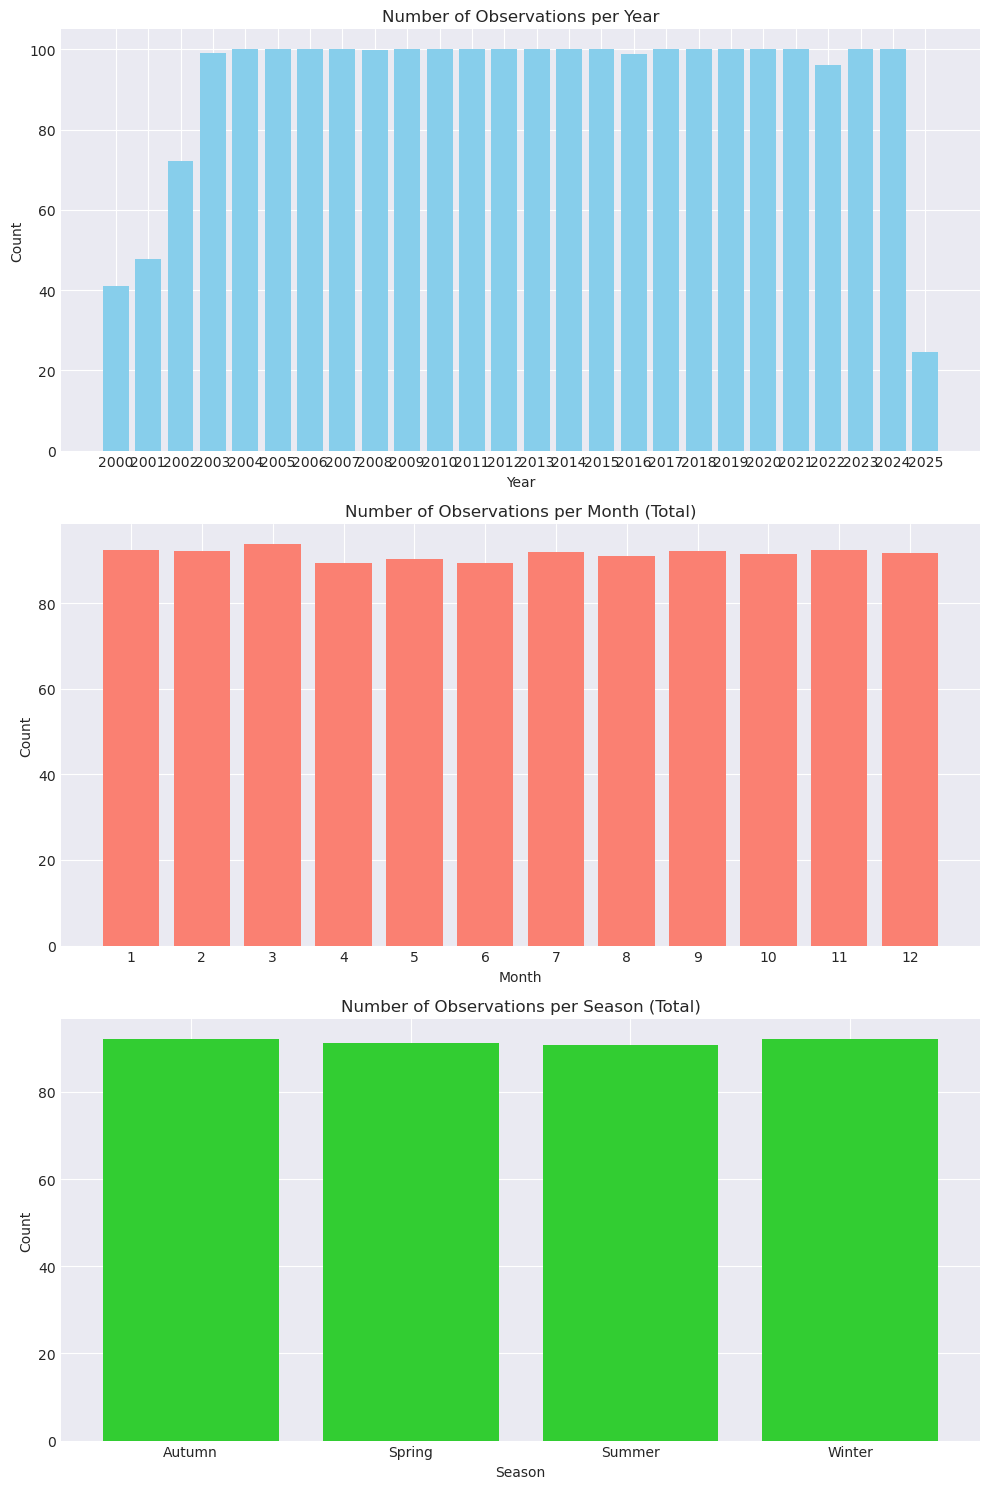

In [27]:
# Visualize
plt.style.use('seaborn-v0_8-darkgrid')

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Yearly observations
axes[0].bar(df_year['Year'], df_year['Coverage (%)'], color='skyblue')
axes[0].set_title('Number of Observations per Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Count')

# Monthly observations
axes[1].bar(df_month['Month'], df_month['Coverage (%)'], color='salmon')
axes[1].set_title('Number of Observations per Month (Total)')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Count')
axes[1].set_xticks(range(1, 13))

# Day of year observations
axes[2].bar(df_season['Season'], df_season['Coverage (%)'], color='limegreen')
axes[2].set_title('Number of Observations per Season (Total)')
axes[2].set_xlabel('Season')
axes[2].set_ylabel('Count')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# TODO: get fraction of uncertain pixels for each month/season, then the same for cloudy and clear pixels 
def monthly_reduce(month): 
    filtered_month = cloud_mask_collection.filter(ee.Filter.eq('month', month))
    cloudy_sum = filtered_month.map(lambda img: img.select('cld').eq(1)).sum()
    clear_sum = filtered_month.map(lambda img: img.select('cld').eq(0)).sum()
    valid = cloudy_sum.add(clear_sum)
    
    cloud_frac = cloudy_sum.divide(valid).rename('cloud_fraction') \
        .set('month', month)
    return cloud_frac

months = ee.List.sequence(1,12)
monthly_cloud = ee.ImageCollection(months.map(monthly_reduce))
print(monthly_cloud)

def seasonal_reduce(season):
    filtered = cloud_mask_collection.filter(ee.Filter.eq('season', season))

    cloudy_sum = filtered.map(lambda img: img.select('cld').eq(1)).sum()
    clear_sum = filtered.map(lambda img: img.select('cld').eq(0)).sum()
    valid = cloudy_sum.add(clear_sum)

    cloud_frac = cloudy_sum.divide(valid).rename('cloud_fraction') \
        .set('season', season)
    return cloud_frac

seasons = ee.List(['Winter', 'Spring', 'Summer', 'Autumn'])
seasonal_cloud = ee.ImageCollection(seasons.map(seasonal_reduce))
print(seasonal_cloud)

In [ ]:
# Export months
for month in range(1, 13):
    image = monthly_cloud.filter(ee.Filter.eq('month', month)).first()
    # Define export task
    task = ee.batch.Export.image.toDrive(
        image=image,  # Image to export
        description=f'CloudFraction_Month_{month}',  # Task description
        folder= 'GEE_exports',
        fileFormat='GeoTIFF',  # Output format
        region=bergen_roi,  # The region of interest (AOI)
        scale=1000,  # Resolution (in meters)
        fileNamePrefix=f'cloud_fraction_month_{month:02d}'  # Prefix for file name
    )

    # Start export
    task.start() # todo: image has no bands error 

# Export seasons
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']

for season in seasons:
    image = seasonal_cloud.filter(ee.Filter.eq('season', season)).first()
    task = ee.batch.Export.image.toDrive(
        image=image,  
        description=f'CloudFraction_{season}',  
        folder= 'GEE_exports',
        fileFormat='GeoTIFF',  
        region=bergen_roi,  
        scale=1000,  
        fileNamePrefix=f'cloud_fraction_month_{season.lower()}'  
    )
    task.start()